# Spotify statistics similar to yearly Wrapped

The following notebook analyses Spotify streaming data, mostly following the idea of Wrapped and thus only data from 2021 is included. The streams used are between January 1st and October 31st 2021. Although I do not know exactly when the data collecting for Wrapped ends, the Internet suggests October 31st and as the only alternative was to take a guess myself, I am using this date.

## Imports

In [434]:
import pandas as pd
import numpy as np
import spotipy
from datetime import datetime
from collections import Counter, defaultdict
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from random import sample
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt

## Data preprocessing

The data is a combination of data directly from Spotify (using the Spotipy API) and last.fm as I wasn't able to get my Spotify statistics from the Spotify page quickly enough.

Using last.fm I was able to retrieve my streaming history since I created the account there (in 2018).

First I'm reading in the data and looking at what's in it to see how to proceed.

In [2]:
data = pd.read_csv("streams.csv", header=None, names=["artist", "album", "song", "time"])

In [3]:
data.head()

,artist,album,song,time
0,Beulahbelle,Tully (Music from the Motion Picture),You Only Live Twice,11 Dec 2021 19:23
1,Maya Hawke,Blush,So Long,11 Dec 2021 19:19
2,Emily Lind,Tantra Practice,Tantra Practice,11 Dec 2021 19:15
3,Taylor Swift,Red (Taylor's Version),Nothing New (feat. Phoebe Bridgers) (Taylor’s ...,11 Dec 2021 19:11
4,Lizzy McAlpine,Give Me A Minute,To the Mountains,11 Dec 2021 19:07


As can be seen, the specific time is given for each song but it is given as a string so first I will change it to datetime type. After that I will keep all streams between January 1st and October 31st 2021.

In [4]:
data["time"] = pd.to_datetime(data["time"], format="%d %b %Y %H:%M")

In [6]:
data = data.loc[(data["time"] >= "2021-01-01 00:00:00") & (data["time"] <= "2021-10-31 23:59:59")]

The above dataframe now only includes streams from the wanted timeframe. Next I will the find counts for each song per month. For this the data will be aggregated by artist, song and month from the time column. I will also find yearly counts using the same method but leaving month out of the aggregation.

In [112]:
monthly_streams = data.groupby([data["artist"], data["song"], data["time"].dt.month]).agg(count=("time", "count")).reset_index()
yearly_streams = data.groupby([data["artist"], data["song"]]).agg(count=("time", "count")).reset_index()

In [110]:
yearly_streams.sort_values("count", ascending=False).head()

,artist,song,count
624,Barbara Pravi,Voilà,5918
605,Barbara Pravi,Le jour se lève,1244
3265,Simon & Garfunkel,April Come She Will,1207
594,Barbara Pravi,CHAIR,777
479,Arisa,Potevi fare di più,672


I will also save monthly and yearly artist counts aggregating by artist.

In [153]:
monthly_artist_streams = data.groupby([data["artist"], data["time"].dt.month]).agg(count=("time", "count")).reset_index()
yearly_artist_streams = data.groupby([data["artist"]]).agg(count=("time", "count")).reset_index()

Now that the data has been preprocessed into a suitable format, the analysis tasks are up next.

## Wrapped type analysis and improvement suggestions

The data obtained above can be used for a Wrapped style analysis to provide users insights into their streaming statistics. The analysis will mainly be done using stream counts of songs but the same style would also work for artist streams, album streams or podcast listening counts.

### Top songs

The heart and soul of Wrapped is the top songs playlist and statistics. Top songs can be presented simply by ordering them based on counts. This yields the following top 5 songs. I am using top 5 as this is the number of songs presented in the Wrapped slideshow.

In [116]:
yearly_streams.sort_values("count", ascending=False).head()

,artist,song,count
624,Barbara Pravi,Voilà,5918
605,Barbara Pravi,Le jour se lève,1244
3265,Simon & Garfunkel,April Come She Will,1207
594,Barbara Pravi,CHAIR,777
479,Arisa,Potevi fare di più,672


This is a wonderful statistic to have and something most users probably appreciate. But if you're anything like me, this will not be entirely new information and will leave you yearning for more.

Based on this I propose the following addition: top songs that have stayed with you throughout the year.

We all have songs that we randomly find one day and listen to.. like a lot, in a few days but never come back to after. And then we have the favourites. The ones we may not stream massively, but they're the only constant in our lives, with streams from the very first day of the year up until the last. This part would show users just those songs. The very favourites they just keep coming back to.

For this I will utilise the monthly streams data. For the first approach I will save top 20 songs per month and find songs that appeared during the most months. As the point is to find songs that were listened to the most throughout the entire year, stream counts will only be taken into account as tiebreakers between songs that have been streamed the same amount of months.

In [148]:
monthly_top = {}

for i in range(1, 11):
    top20 = monthly_streams[monthly_streams["time"] == i].sort_values("count", ascending=False)[["artist", "song"]].head(20)
    # NB! the song combination into string is a placeholder as Counter was the most convenient thing to use and
    # required strings but later analysis can become problematic if artist names include hyphens
    songs = (top20["artist"] + " - " + top20["song"]).values.tolist()
    monthly_top[i] = songs

In [155]:
month_counts = Counter(song for top20 in monthly_top.values() for song in top20).most_common()

In [157]:
top_songs = []

for idx, song in enumerate(month_counts):
    if len(top_songs) < 5:
        top_songs.append(song)
        continue
        
    if song[1] == top_songs[-1][1]:
        top_songs.append(song)
    else:
        break

In [158]:
top_songs

[('Barbara Pravi - Voilà', 8),
 ('Barbara Pravi - CHAIR', 4),
 ("Barbara Pravi - Reviens pour l'hiver", 4),
 ('Barbara Pravi - Le Malamour - Acoustic', 4),
 ("Barbara Pravi - Personne d'autre que moi", 4),
 ('Barbara Pravi - Saint-Raphaël', 4),
 ('Barbara Pravi - Barcelone', 4),
 ('Barbara Pravi - La fête', 4),
 ('Barbara Pravi - Le jour se lève', 4)]

As can be seen, this gives more than the 5 songs to be reported to the user. The songs will now be ordered based on stream counts.

In [198]:
top_5 = []

for idx, song in enumerate(top_songs):
    # If the number of months the song was streamed in doesn't match the next one,
    # it can be added to the top 5 songs playlist
    if idx < len(top_songs) - 1 and song[1] != top_songs[idx + 1][1]:
        top_5.append(song[0])
        
        if len(top_5) == 5:
            break
    
    # otherwise I will find all songs with the same count and order them
    else:
        song_count = song[1]
        same_count = [s[0] for s in top_songs if s[1] == song_count]
        indices = [i for i, s in enumerate(top_songs) if s[1] == song_count]
        
        song_streams = []
        
        for song_info in same_count:
            artist, title = song_info.split(" - ", 1)
            count = yearly_streams[(yearly_streams["artist"] == artist) & (yearly_streams["song"] == title)]["count"].tolist()[0]
            song_streams.append((artist, title, count))
            
        sorted_streams = sorted(song_streams, key=lambda x: x[-1], reverse=True)
        
        # realistically there should also be a check whether songs here
        # are equal in stream counts but this is ignored for now as the 
        # point is to provide a general idea
        for stream in sorted_streams:
            top_5.append(" - ".join(stream[:2]))
            
            if len(top_5) == 5:
                break
                
        idx = indices[-1] + 1
        if idx == len(top_songs):
            break

In [199]:
top_5

['Barbara Pravi - Voilà',
 'Barbara Pravi - Le jour se lève',
 'Barbara Pravi - CHAIR',
 "Barbara Pravi - Reviens pour l'hiver",
 'Barbara Pravi - Le Malamour - Acoustic']

Now looking at these songs we can see that while there is some overlap between the top 5 songs by overall streams and top 5 songs by monthly trends, the lists don't match entirely. How much they overlap will vary from person to person but would be interesting to see. Similarly we could find songs that were streamed the most during a specific point in time but never again.

Similarly we can find top artists overall and by monthly trends.

In [200]:
yearly_artist_streams.sort_values("count", ascending=False).head()

,artist,count
166,Barbara Pravi,15025
8,ABBA,2518
1443,Simon & Garfunkel,1293
127,Arisa,1127
1712,Wiktoria,1082


In [204]:
monthly_artist_top = {}

for i in range(1, 11):
    top20 = monthly_artist_streams[monthly_artist_streams["time"] == i].sort_values("count", ascending=False)[["artist"]].head(20)
    songs = top20["artist"].values.tolist()
    monthly_artist_top[i] = songs

In [206]:
month_artist_counts = Counter(song for top20 in monthly_artist_top.values() for song in top20).most_common()

In [207]:
top_artists = []

for idx, artist in enumerate(month_artist_counts):
    if len(top_artists) < 5:
        top_artists.append(artist)
        continue
        
    if artist[1] == top_artists[-1][1]:
        top_artists.append(artist)
    else:
        break

In [208]:
top_artists

[('Barbara Pravi', 10),
 ('Taylor Swift', 8),
 ('Wiktoria', 7),
 ('Maisie Peters', 7),
 ('ABBA', 7)]

From here we can see that 5 artists already emerge, so I will currently do no further analysis (although knowing the top 5 artists overall from above, we know the final three would otherwise be rearranged).

From here we can similarly see that while there is some overlap, not all artists are the same.

While the methodology needs refining, I believe this type of analysis can provide valuable additional insight which the users can appreciate.

### Top genres

Next I will find the top genres of my streams this year. For the actual Wrapped this may be found differently, but since I can only obtain artists' genres, I will use that information. For each artist, I will extract their genres and then use different approaches to find top genres.

In [212]:
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET))

In [229]:
def artist_genres(artist_name, spotify=spotify):
    result = spotify.search(artist_name)
    try:
        track = result['tracks']['items'][0]
        artist = spotify.artist(track["artists"][0]["external_urls"]["spotify"])
        return artist["genres"]
    except:
        return []

In [223]:
genre_counts = defaultdict(int)
artists_genres = {}

for idx, row in yearly_artist_streams.iterrows():
    artist, count = row
    genres = artist_genres(artist)
    artist_genres[artist] = genres
    for genre in genres:
        genre_counts[genre] += count

First I found top genres by just using the artists' stream counts as genre counts and adding them together. While this gives some insight into overall streaming, it doesn't seem to be too informative, especially when combining knowledge regarding genres and artists' stream counts. I understand where 'Eurovision' comes from but it isn't very representative of the streaming nor is it an actual genre.

In [225]:
sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[('eurovision', 16563),
 ('nouvelle chanson francaise', 15049),
 ('pop', 3388),
 ('swedish pop', 2785),
 ('europop', 2615),
 ('rock', 2540),
 ('classic rock', 1936),
 ('mellow gold', 1921),
 ('folk rock', 1853),
 ('folk', 1726)]

My actual top genres seem to start emerging after the top 5, as these start coming from more artists rather than bingeing one artist on repeat. To investigate this, the next approach is to discard artist stream counts entirely and just count the number of occurrences of each genre across all artists I've streamed.

First I will take all artists into account.

In [233]:
genre_occurrences = defaultdict(int)

for artist, genres in artists_genres.items():
    for genre in genres:
        genre_occurrences[genre] += 1

In [234]:
sorted(genre_occurrences.items(), key=lambda x: x[1], reverse=True)[:10]

[('pop', 180),
 ('rock', 129),
 ('dance pop', 101),
 ('pop rock', 94),
 ('modern rock', 93),
 ('indie folk', 90),
 ('indie pop', 83),
 ('stomp and holler', 77),
 ('mellow gold', 61),
 ('eurovision', 60)]

The results obtained now are vastly different from the original results. This is not necessarily good either, as this approach is likely too strict. I will first make adjustments to this approach.

Firstly, this takes into account each artist. However each streamed artist may not be representative of the musical taste. To counter this issue, I will only keep artists that I've streamed more than one time. This should help somewhat overcome the issue, as it removes artists I may have streamed based on different suggestions (friends, Spotify, different playlists etc) but did not like and thus never listened to again.

In [240]:
if yearly_artist_streams[yearly_artist_streams["artist"] == artist]["count"].values[0] > 1:
    print(artist)

In [241]:
relevant_genre_occurrences = defaultdict(int)

for artist, genres in artists_genres.items():
    if yearly_artist_streams[yearly_artist_streams["artist"] == artist]["count"].values[0] == 1:
        continue
    for genre in genres:
        relevant_genre_occurrences[genre] += 1

In [242]:
sorted(relevant_genre_occurrences.items(), key=lambda x: x[1], reverse=True)[:10]

[('pop', 101),
 ('rock', 80),
 ('indie folk', 55),
 ('pop rock', 53),
 ('indie pop', 51),
 ('modern rock', 50),
 ('stomp and holler', 49),
 ('dance pop', 48),
 ('mellow gold', 44),
 ('classic rock', 40)]

This seems to already be an improvement. However now we have completely disregarded the number of times an artist was streamed. One way would be to use some sort of scaling (like MinMax) but this would result in the same order as just using the counts, just the numbers would be smaller. 

Instead I will give an extra increase to the top 15 (this exact number can be changed later) artists I've streamed the most. This is a fairly simple approach and a more refined one can be determined later. It would also be better if this was done on top songs instead of top artists as one artist can have vastly different songs, however I couldn't obtain that data so for now artist genres will do.

In [333]:
yearly_artist_streams.sort_values("count", ascending=False).head(16).tail(1)

,artist,count
1233,Olivia Rodrigo,370


In [334]:
artists_coefficients = {}
artists_coefficients2 = {}
extra = 15 # 4

for idx, row in yearly_artist_streams.sort_values("count", ascending=False).head(15).iterrows():
    #if i % 4 == 0:
    #    extra -= 1
    artist, count = row
    artists_coefficients[artist] = extra
    artists_coefficients2[artist] = count / 370
    extra -= 1
    # i += 1

In [335]:
final_genre_occurrences = defaultdict(int)
final_genre_occurrences2 = defaultdict(int)

for artist, genres in artists_genres.items():
    if yearly_artist_streams[yearly_artist_streams["artist"] == artist]["count"].values[0] == 1:
        continue
    for i, genre in enumerate(genres):
        if artist in artists_coefficients:
            final_genre_occurrences[genre] += artists_coefficients[artist]
            final_genre_occurrences2[genre] += artists_coefficients2[artist]
        else:
            final_genre_occurrences[genre] += 1
            final_genre_occurrences2[genre] += 1

In [336]:
sorted(final_genre_occurrences.items(), key=lambda x: x[1], reverse=True)[:11]

[('pop', 110),
 ('rock', 92),
 ('mellow gold', 56),
 ('indie folk', 55),
 ('indie pop', 55),
 ('pop rock', 53),
 ('eurovision', 52),
 ('classic rock', 52),
 ('modern rock', 50),
 ('stomp and holler', 49),
 ('dance pop', 48)]

In [337]:
sorted(final_genre_occurrences2.items(), key=lambda x: x[1], reverse=True)[:11]

[('pop', 101.93783783783785),
 ('rock', 82.49459459459459),
 ('eurovision', 70.52162162162162),
 ('indie folk', 55),
 ('pop rock', 53),
 ('indie pop', 51.35675675675676),
 ('modern rock', 50),
 ('stomp and holler', 49),
 ('dance pop', 48),
 ('mellow gold', 46.494594594594595),
 ('nouvelle chanson francaise', 44.608108108108105)]

These were found in two different ways. First the top 15 got an added coefficient based on their placement. This means the most streamed artist counted 15 times more than songs below top 15, second was 14 times more and so on. The second way uses a scale where the artist's stream count is divided by the stream count of the 16th place (first that doesn't get an extra push). Neither option is ideal and need refinement, but provide a bit more insight than using only stream counts or only single genres separately.

Next I will discuss a potential improvement in genres themselves. For this I will demonstrate using my top genres from this year's wrapped.

The top genres for me were:

1. Eurovision
2. French Pop
3. Italian Pop
4. Swedish Pop
5. Indie Folk

While this is nice to know, it doesn't really say much about the actual genres, as the only one that is really a genre is 'indie folk'. Eurovision, while something I enjoy, is not exactly a genre and doesn't really give insight into my listening habits. 

Most importantly however, country based genres seem to affect the statistics way too much while not giving much insight into what the user actually enjoys. Especially with smaller countries or artists not so popular, everything seems to be grouped into a genre called '[insert nationality] pop', often even disregarding the actual genre. In addition to not telling much in wrapped, this can also affect other aspects of Spotify, especially suggestions, as songs/artists from the same country will keep getting recommended, limiting the options severely.

The idea for a fix is fairly simple: separate countries and genres. This would essentially mean an artist has a separate field for their country and from genres country/nationality based elements are removed entirely. This gives two separate statistics for Wrapped and allows to regulate the suggestions (higher importance to genre and lower importance to country or determine based on user's streaming history which one should be more important).

The below illustrates the grouping of artists based on genres when using language based genres vs not using them. For this I will take a subset of the artists I've streamed. Since my top genres included French, Italian and Swedish pop, these are the ones I'm using. For the fourth element I'm taking artists that have no country based genres. Clustering is done using simple KMeans.

In [352]:
country_genres = defaultdict(list)
nationalities = ["French", "Italian", "Swedish"]

for artist, genres in artists_genres.items():
    for nationality in nationalities:
        g = f"{nationality} Pop".lower()
        if g in genres:
            country_genres[g].append(artist)
            break
    country_genres["other"].append(artist)

In [355]:
len(country_genres["french pop"]), len(country_genres["italian pop"]), len(country_genres["swedish pop"])

(29, 19, 25)

The lengths of French, Italian and Swedish pop artists lists are quite similar so I will keep all of them. I will choose 20 random artists without any of these country based genres for the other category. 

In [364]:
others = sample(country_genres["other"], 20)

In [366]:
sample_artists_genres = {}

for l in [country_genres["french pop"], country_genres["italian pop"], country_genres["swedish pop"], others]:
    for artist in l:
        sample_artists_genres[artist] = artists_genres[artist]

In [378]:
mlb = MultiLabelBinarizer()
country_genres_df = pd.DataFrame(mlb.fit_transform(sample_artists_genres.values()), columns=mlb.classes_, index=sample_artists_genres.keys())

Since there are essentially four different clusters, I will also use this number for KMeans.

In [380]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(country_genres_df.values)

KMeans(n_clusters=4, random_state=0)

Now I'm dividing the results into the different clusters and seeing what was found.

In [382]:
clusters_countries = defaultdict(list)

for idx, label in enumerate(kmeans.labels_):
    clusters_countries[label].append(country_genres_df.index[idx])

In [384]:
for i, artists_ in clusters_countries.items():
    print(f"Cluster no {i}")
    for artist in artists_:
        print(artist, artists_genres[artist])
    print("-----------------")

Cluster no 0
Amel Bent ['chanson', 'francoton', 'french pop']
Benjamin Biolay ['chanson', 'french indie pop', 'french pop', 'french rock', 'nouvelle chanson francaise']
Calogero ['chanson', 'francoton', 'french pop', 'french rock']
Chimène Badi ['chanson', 'french pop']
Clara Luciani ['french indie pop', 'french indietronica', 'french pop']
Dalida ['chanson', 'french pop']
Emmanuel Moire ['chanson', 'francoton', 'french pop']
Gaëtan Roussel ['francoton', 'french indie pop', 'french pop', 'variete francaise']
Gims ['francoton', 'french hip hop', 'french pop', 'rap conscient']
Grand Corps Malade ['chanson', 'francoton', 'french pop', 'french rock']
Indila ['french pop']
Jean-Louis Aubert ['chanson', 'french pop', 'french rock']
Johnny Hallyday ['chanson', 'francoton', 'french pop', 'ye ye']
Joyce Jonathan ['chanson', 'francoton', 'french pop']
Julie Zenatti ['chanson', 'french pop']
Juliette Armanet ['chanson', 'electro-pop francais', 'french indie pop', 'french indietronica', 'french po

From the results we can clearly see that for the most part country based clusters emerge and everything else is put together, regardless of how similar they really are.

Next I will try to remove country based genres. I will simply remove "French Pop", "Italian Pop" and "Swedish Pop" as they often seem to be umbrella terms for any genre from said country. For other genres I will remove nationality based words, for example "French Rock" would just become "Rock".

In [410]:
sample_artists_genres2 = {}

for l in [country_genres["french pop"], country_genres["italian pop"], country_genres["swedish pop"], others]:
    for artist in l:
        genres = artists_genres[artist]
        final_genres = []
        for genre in genres:
            if genre in ["french pop", "italian pop", "swedish pop"]:
                continue
            for n in ["french", "italian", "swedish"]:
                genre = genre.replace(n, "").strip()
            final_genres.append(genre)
        if len(final_genres) > 0:
            sample_artists_genres2[artist] = final_genres

In [411]:
mlb2 = MultiLabelBinarizer()
genres_df = pd.DataFrame(mlb2.fit_transform(sample_artists_genres2.values()), columns=mlb2.classes_, index=sample_artists_genres2.keys())

To compare, I will use 4 clusters like before

In [419]:
kmeans2 = KMeans(n_clusters=4, random_state=0)
kmeans2.fit(genres_df.values)

KMeans(n_clusters=4, random_state=0)

In [420]:
clusters_genres = defaultdict(list)

for idx, label in enumerate(kmeans2.labels_):
    clusters_genres[label].append(genres_df.index[idx])

In [421]:
for i, artists_ in clusters_genres.items():
    print(f"Cluster no {i}")
    for artist in artists_:
        print(artist, sample_artists_genres2[artist])
    print("-----------------")

Cluster no 3
Amel Bent ['chanson', 'francoton']
Benjamin Biolay ['chanson', 'indie pop', 'rock', 'nouvelle chanson francaise']
Calogero ['chanson', 'francoton', 'rock']
Chimène Badi ['chanson']
Dalida ['chanson']
Emmanuel Moire ['chanson', 'francoton']
Grand Corps Malade ['chanson', 'francoton', 'rock']
Jean-Louis Aubert ['chanson', 'rock']
Johnny Hallyday ['chanson', 'francoton', 'ye ye']
Joyce Jonathan ['chanson', 'francoton']
Julie Zenatti ['chanson']
Juliette Armanet ['chanson', 'electro-pop francais', 'indie pop', 'indietronica', 'nouvelle chanson francaise']
Les Frangines ['chanson', 'variete francaise']
Nolwenn Leroy ['chanson', 'francoton']
Thomas Dutronc ['chanson']
Vincent Delerm ['chanson', 'indie pop', 'rock', 'nouvelle chanson francaise']
Yannick Noah ['chanson', 'francoton']
Marie Laforêt ['chanson', 'ye ye']
-----------------
Cluster no 2
Clara Luciani ['indie pop', 'indietronica']
Gaëtan Roussel ['francoton', 'indie pop', 'variete francaise']
Gims ['francoton', 'hip hop

Since now there are more different genres, 4 isn't an ideal number of clusters anymore, but we can see other patterns emerge. For example there's a separate cluster for 'chanson'. While this is still somewhat country-based, it is a specific subgenre of very authentically French songs which makes for a better cluster. This subset is not ideal as more work would need to be done on separating solely country-based genres, but it shows there is definitely potential to find better similarities when removing countries. 

This is clearly an overly simplified way of grouping similar artists as I do not have nearly enough resources or exact knowledge of how Spotify's recommendations work to come up with state-of-the-art solutions now but it shows there's clearly potential when separating countries from genres, as at the end of the day, the genre of an artist or a song is what will be the base for all similarities and will be the most important determining factor in what a user may like.

## Additional song-based statistics

In addition to everything discussed above, there can be additional information regarding someone's top songs that is shared.

First we'll look at daily trends of the top song.

In [425]:
yearly_streams.sort_values("count", ascending=False).iloc[0]["artist"]

'Barbara Pravi'

In [426]:
top_song = yearly_streams.sort_values("count", ascending=False).iloc[0]
top_song_data = data[(data["artist"] == top_song["artist"]) & (data["song"] == top_song["song"])]

In [430]:
top_song_daily = top_song_data.groupby([top_song_data["artist"], top_song_data["song"], top_song_data["time"].dt.date]).agg(count=("time", "count")).reset_index()

In [431]:
top_song_daily

,artist,song,time,count
0,Barbara Pravi,Voilà,2021-01-07,1
1,Barbara Pravi,Voilà,2021-01-29,16
2,Barbara Pravi,Voilà,2021-01-30,56
3,Barbara Pravi,Voilà,2021-01-31,138
4,Barbara Pravi,Voilà,2021-02-01,58
...,...,...,...,...
122,Barbara Pravi,Voilà,2021-10-14,6
123,Barbara Pravi,Voilà,2021-10-15,3
124,Barbara Pravi,Voilà,2021-10-16,2
125,Barbara Pravi,Voilà,2021-10-26,1


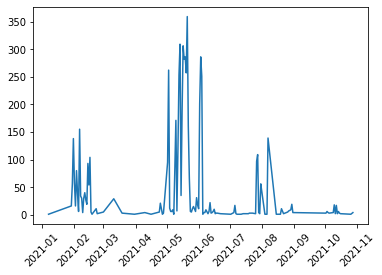

In [439]:
plt.plot(top_song_daily["time"], top_song_daily["count"])
plt.xticks(rotation=45);

In [448]:
top_song_daily.sort_values("count", ascending=False).head()

,artist,song,time,count
54,Barbara Pravi,Voilà,2021-05-21,359
47,Barbara Pravi,Voilà,2021-05-14,309
50,Barbara Pravi,Voilà,2021-05-17,306
52,Barbara Pravi,Voilà,2021-05-19,286
66,Barbara Pravi,Voilà,2021-06-03,286


In [449]:
top_song_daily.shape

(127, 4)

Similarly we can look at monthly trends of the user's top song.

In [450]:
top_song_monthly = top_song_data.groupby([top_song_data["artist"], top_song_data["song"], top_song_data["time"].dt.month]).agg(count=("time", "count")).reset_index()

In [451]:
top_song_monthly

,artist,song,time,count
0,Barbara Pravi,Voilà,1,211
1,Barbara Pravi,Voilà,2,814
2,Barbara Pravi,Voilà,3,38
3,Barbara Pravi,Voilà,4,35
4,Barbara Pravi,Voilà,5,3366
5,Barbara Pravi,Voilà,6,830
6,Barbara Pravi,Voilà,7,307
7,Barbara Pravi,Voilà,8,242
8,Barbara Pravi,Voilà,10,75


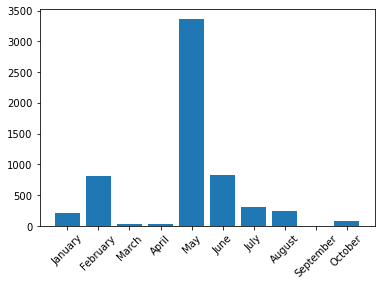

In [456]:
plt.bar(top_song_monthly["time"], top_song_monthly["count"])
plt.xticks(range(1, 11), ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"], rotation=45);

Similar statistics can be provided for top artists and also song characteristics (like acousticness, danceability etc - basically how someone's listening habits changed throughout the year).